# Hydrogeodesy: Monitoring surface waters from space
### Exercise 1: From measured ranges to water level & pre-processed inland altimetry products

Daniel Scherer, DGFI-TUM  
Wintersemester 2022/23

**Contents**
1. Height estimation and retracker comparison
2. Water level time series
3. Waveform analysis (optional)

**Study Area: Lake Stamford (Texas, USA)**  
![AOI](aoi.Png)  
*Figure 1: Lake Stamford*  

| Area Variation | Water Level Variation |
| --- | --- |
| 3 – 18 km² | 426 – 431 m |

First import some required libraries:

In [35]:
import pathlib # Just simplifies the handling of pathes
import netCDF4 as nc # required to open netcdf files
import matplotlib.pyplot as plt # standard plotting library
import numpy as np # fundamental package for scientific computing with Python

### 1. Height estimation and retracker comparison

Satellite altimetry data is commonly provided by **pass** and **cyle** numbers.  
The pass number identifies a segment (usually pole to pole or equator intersection to equator intersection) of the repeating groundtrack.  
The cycle number identifies the repetition of the groundtrack.

We use data with DGFI-TUM's internal dataformat **MVA**.
  
The example water body "Lake Stamford" intersects with pass number 230 of the Jason-2 mission.  
Please choose a cycle number between 50 and 300 when loading the data below:

In [ ]:
cycle_nr = ... # Choose a number between 50 and 300 
mva_data_root = pathlib.Path('data/lake_stamford/mva')
dset = nc.Dataset(mva_data_root / f'jason2_{cycle_nr:03d}_0230.nc')

Now we load all variables:

In [8]:
lon = dset["glon"][:] # longitude
lat = dset["glat"][:] # latitude
jday = dset["jday"][:] # julian day of measurement
geoh = dset["geoh"][:] # geoid
hsat = dset["hsat"][:] # satellite height
wtrop = dset["wtrop"][:] # wet troposhpere component
dtrop = dset["dtrop"][:] # dry troposphere component
ionos = dset["ionos"][:] # ionosphere
etide = dset["etide"][:] # earth tide
ptide = dset["ptide"][:] # pole tide
uralt = dset["uralt"][:] # uncoreected range
ralt_ocean = dset["ralt_ocean"][:] # range from ocean retracker
ralt_ice = dset["ralt_ice"][:] # range from ice retracker
ralt_dahiti = dset["ralt_imth_dahiti"][:] # range from dahiti (improved thresholds) retracker
dset.close()

Calculate the water level using range from the ice, ocean, and dahiti retracker:

In [61]:
heights_ice = ...
heights_ocean = ...
heights_dahiti = ...

Now we can plot the calculated water levels along the latitude component of the orbit groundtrack:

In [ ]:
fig, ax = plt.subplots()
ax.plot(lat,heights_ice,marker='.',color="r",label='Ice')
ax.plot(lat,heights_ocean,marker='.',color="k",label='Ocean')
ax.plot(lat,heights_dahiti,marker='.',color="b",label='DAHITI')
plt.legend(title='Retracker')
plt.xlabel("Latitude [˚]")
plt.ylabel("Water Level [m]")
plt.title(f"Retracked Water Level for Lake Stamford. Jason-2 Pass 230, Cycle {cycle_nr:03d}")
plt.show()

Think about the following questions:  
- Which geophysical correction is most significant?  
- What effect do you recognize looking at the plotted heights along the altimeter track?  
- How do the results differ by retracker?  
- What would be the best method to calculate a suitable single water level for this overflight (cycle)?  

### 2. Water Level Time Series

Based on Figure 1 and your plotted heights by latitude, chose suitable outlier criteria for latitude and height so we can reject corrupted measurements in the following.

In [75]:
min_lat = 33.06
max_lat = 33.07
min_height = 426
max_height = 435

This time we define a function for applying the corrections:

In [59]:
def get_heights(dset, retracker : str):
    return dset['hsat'][:] - dset[retracker][:] - dset["geoh"][:] - dset["etide"][:] - dset["ptide"][:] - dset["ionos"][:] - dset["dtrop"][:] - dset["wtrop"][:]

Now we iterate all cycles and calculate the mean height per retracker and cycle:

In [76]:
mva_data_root = pathlib.Path('data/lake_stamford/mva')

x_jdays_ocean, y_heights_ocean = [], []
x_jdays_ice, y_heights_ice = [], []
x_jdays_dahiti, y_heights_dahiti = [], []

for mva_file in sorted(mva_data_root.iterdir()):
    dset = nc.Dataset(mva_file)

    # Estimate Heights
    h_ocean = get_heights(dset, 'ralt_ocean')
    h_ice = get_heights(dset, 'ralt_ice')
    h_dahiti = get_heights(dset, 'ralt_imth_dahiti')
    lat = dset['glat'][:]
    jday = dset['jday'][:]

    # Outlier Rejection
    lat_mask = np.bitwise_and(lat > min_lat, lat < max_lat)
    ocean_mask = np.bitwise_and(h_ocean > min_height, h_ocean < max_height)
    ice_mask = np.bitwise_and(h_ice > min_height, h_ice < max_height)
    dahiti_mask = np.bitwise_and(h_dahiti > min_height, h_dahiti < max_height)
    
    # get mean date
    x_jdays_ice.append(np.nanmean(jday[ice_mask & lat_mask]))
    x_jdays_ocean.append(np.nanmean(jday[ocean_mask & lat_mask]))
    x_jdays_dahiti.append(np.nanmean(jday[dahiti_mask & lat_mask]))
    
    # get mean height
    y_heights_ice.append(np.nanmean(h_ice[ice_mask & lat_mask]))
    y_heights_ocean.append(np.nanmean(h_ocean[ocean_mask & lat_mask]))
    y_heights_dahiti.append(np.nanmean(h_dahiti[dahiti_mask & lat_mask]))
    
    dset.close()

Plot the Time Series:

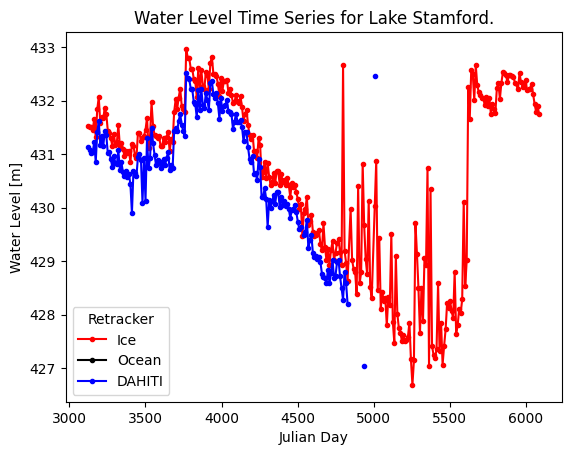

In [78]:
fig, ax = plt.subplots()
ax.plot(x_jdays_ice,y_heights_ice,marker='.',color="r",label='Ice')
ax.plot(x_jdays_ocean,y_heights_ocean,marker='.',color="k",label='Ocean')
ax.plot(x_jdays_dahiti,y_heights_dahiti,marker='.',color="b",label='DAHITI')
plt.legend(title='Retracker')
plt.xlabel("Julian Day")
plt.ylabel("Water Level [m]")
plt.title("Water Level Time Series for Lake Stamford.")
plt.show()

- What differences do you notice between the time series?

- Can you see improvements or overall changing results when adjusting the outlier criteria in 2.1?

### 3. Waveform Analysis

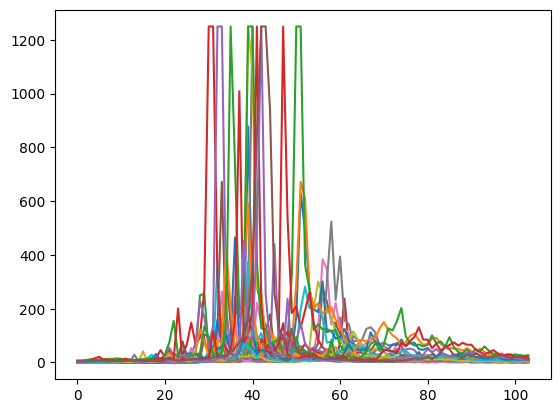

In [11]:
dset = nc.Dataset(mva_data_root / f'jason2_050_0230.nc')
for waveform in dset['waveform_dahiti']:
    plt.plot(waveform)
plt.show()
dset.close()